# Wind chill example - building and improving a simple Neural Network in PyTorch

This example was adapted from the excellent [notebook provided by EUMETNET](https://github.com/eumetnet-e-ai/tutorials/blob/main/tutorial1/1_3_basic_wind_chill_example.ipynb)

Let's use a simple physical model to look at building and improving a simple Neural Network model using the `PyTorch` framework. **Wind Chill Factor** is defined using the following formula, deriving it from Air Temperature and Wind Speed:


$$
T_{WC} = 13.12 + (0.6215 * T_{AIR}) - (11.37 * WS^{0.16}) + (0.3965 * T_{AIR} * WS^{0.16})
$$

**Want to know more about Wind Chill Factor?** See details here on the [Met Office website](https://www.metoffice.gov.uk/weather/learn-about/weather/types-of-weather/wind/wind-chill-factor).

This notebook requires the following packages: `PyTorch`, `Numpy`, `Matplotlib`.

## Getting started

Import relevant libraries and create some random input ($X$) data and the target ($y$) data using the equation defined above (which represents the _perfect_ model).

In [43]:
# Import the required libraries
# PyTorch (imported as "torch") is a Python-based Machine Learning library 
# that is very popular, and scales easily to GPU usage
import torch
import torch.nn as nn
import torch.optim as optim

# Numpy allows us to create and manipulate arrays and matrices
import numpy as np

# Matplotlib is the main plotting tool
import matplotlib.pyplot as plt

# Generate some data
n_samples = 500                              # Size of the dataset

temp = np.random.uniform(-20, 10, n_samples)   # Temperature in Celsius
wspd = np.random.uniform(0, 50, n_samples)     # Wind speed in km/h


# Use Wind Chill formula to generate a target dataset (i.e. exactly matching the scientific model)
# Use a Python function so we can re-use it later when creating the Validation Dataset
def calc_wind_chill_temp(temp, wspd):
    return 13.12 + 0.6215 * temp - 11.37 * (wspd ** 0.16) + 0.3965 * temp * (wspd ** 0.16)

wc_temp = calc_wind_chill_temp(temp, wspd)

Let's plot the data so that we can see the range of values.

Text(0, 0.5, 'Wind speed (km/h)')

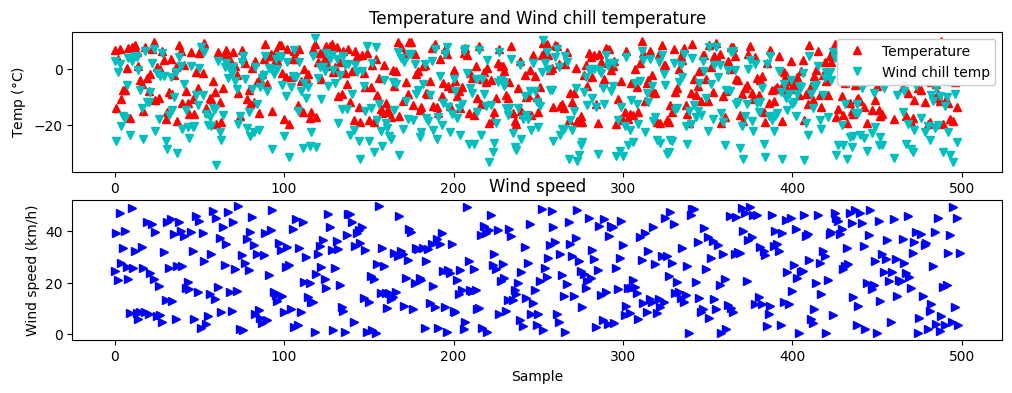

In [44]:
# Create a figure with two axes (a.k.a. plot windows)
fig, axes = plt.subplots(2, 1, figsize=(12, 4))
ax1, ax2 = axes[0], axes[1]

# Plot the temperatures on the first plot
ax1.plot(temp, "r^", linewidth=0.5, label="Temperature")
ax1.plot(wc_temp, "cv", label="Wind chill temp")
_ = ax1.legend(loc="upper right", framealpha=1)
ax1.set_title("Temperature and Wind chill temperature")
ax1.set_xlabel("Sample")
ax1.set_ylabel("Temp ($\degree$C)")

# Plot the wind speed on the second plot
ax2.plot(wspd, "b>", label="Wind speed")
ax2.set_title("Wind speed")
ax2.set_xlabel("Sample")
ax2.set_ylabel("Wind speed (km/h)")

## Create a Training Dataset to train a simple Neural Network

We are using PyTorch `Numpy` arrays to generate the data, then we convert them to `PyTorch` tensors so that they are ready for use in PyTorch.

In [45]:
x_train = torch.tensor(np.column_stack((temp, wspd)), dtype=torch.float32)
y_train = torch.tensor(wc_temp, dtype=torch.float32).view(-1, 1)

Now we will build a neural network to calculate the Wind Chill Temperature. We are building it as a sub-class of the PyTorch `torch.nn.Module` class.

Some notes about the class:
- The `__init__` method should call the super class constructor.
- "fc" stands for _fully connected_ layers - i.e. every input node connects to every output node.
- "relu" is the non-linear activation function, defined as: zero for all negative inputs; x for all positive inputs x.
- The `forward` method is required to run the model.
  - Each component consumes the output of the last component (`x`)

In [46]:
# Step 2: Build a Neural Network Model with Hidden Layers
class WindChillModel(nn.Module):
    def __init__(self):
        super(WindChillModel, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # First hidden layer - "fc" is fully connected
        self.fc2 = nn.Linear(20, 20)  # Second hidden layer
        self.fc3 = nn.Linear(20, 1)  # Output layer
        self.relu = nn.ReLU()  # Activation function
    
    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply ReLU after the first hidden layer
        x = self.relu(self.fc2(x))  # Apply ReLU after the second hidden layer
        x = self.fc3(x)  # Output layer (no activation for regression)
        return x

model = WindChillModel()

Define a loss function, to measure the loss - here we use Mean Squared Error (MSE).

Define an optimiser, which handles updating the weights during each epoch. It includes the learning rate (`lr`) which tells the model how quickly it should travel down the gradient towards its estimated minimum.

In [47]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

**Start the training**

Now we define 10,000 epochs to train over. That means the model will perform its calculations, examine the loss (the difference between the actual result (`y_pred`) and target result (`y_train`).

In [48]:
# Training loop
train_loss = []  # Initialize loss list
n_epochs = 10_000  # Set number of epochs

for epoch in range(n_epochs):
    model.train()  # Set the model to train mode
    optimizer.zero_grad()  # Clear the gradients (important in PyTorch)

    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Compute loss

    loss.backward()  # Backpropagate error
    optimizer.step()  # Update weights

    # Print loss every 500 epochs
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')
    
    train_loss.append(loss.item())  # Save the loss

Epoch [1000/10000], Loss: 0.6337
Epoch [2000/10000], Loss: 0.3210
Epoch [3000/10000], Loss: 0.1307
Epoch [4000/10000], Loss: 0.0856
Epoch [5000/10000], Loss: 0.0504
Epoch [6000/10000], Loss: 0.0254
Epoch [7000/10000], Loss: 0.0193
Epoch [8000/10000], Loss: 0.0159
Epoch [9000/10000], Loss: 0.0144
Epoch [10000/10000], Loss: 0.0133


**What are the model parameters?**

The model parameters are the weights and biases stored inside the model.
They are updated at the end of each epoch. At the end of the training they should contain optimised values for the type of prediction or inference required.

In [49]:
def show_model_params(model):
    params = [i for i in model.parameters()]
    
    print("The model weights and biases (parameters) are:")
    for param in params:
        size = param.size()
        first_3 = param[:3] if len(size) == 1 else param[:3, 0]
        print(f"\tShape = {param.size()}; First few: {first_3.tolist()}")

show_model_params(model)

The model weights and biases (parameters) are:
	Shape = torch.Size([20, 2]); First few: [0.05723504722118378, -0.6254087686538696, 0.6018710136413574]
	Shape = torch.Size([20]); First few: [-2.490553617477417, -0.27972713112831116, -0.24545152485370636]
	Shape = torch.Size([20, 20]); First few: [-0.34691131114959717, -0.19255468249320984, 0.07803899794816971]
	Shape = torch.Size([20]); First few: [0.10225757956504822, -0.3089631199836731, 0.14345858991146088]
	Shape = torch.Size([1, 20]); First few: [-0.27427661418914795]
	Shape = torch.Size([1]); First few: [-0.0985756441950798]


**Let's examime the loss**

In this plot, we show how the Loss is reduced as the training continues. Also, the rate of change starts to decrease as the model gets more accurate and the amount of possible improvement dwindles.

In [50]:
def plot_loss_curves(datadict, n_epochs):
#    ax.plot(np.arange(n_epochs), train_loss, label="training loss")
    fig, ax = plt.subplots()

    for label, loss_data in datadict.items():
        ax.plot(np.arange(n_epochs), loss_data, label=label)

    ax.set_title("Plot of Log Loss vs Epoch number") 
    ax.set_yscale("log")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")

    ax.legend()
    fig.tight_layout()

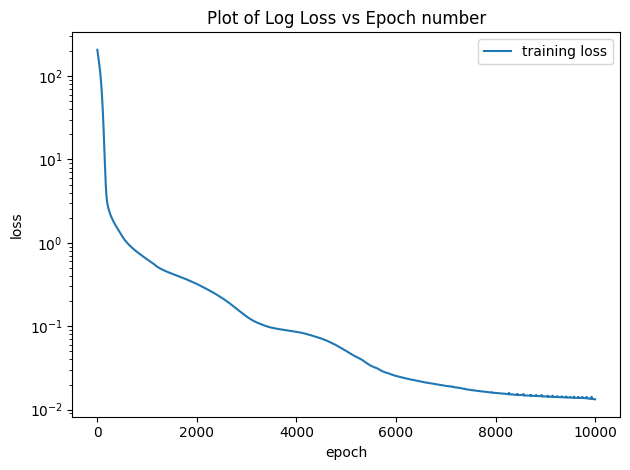

In [51]:
plot_loss_curves({"training loss": train_loss}, n_epochs)

## Create a Validation Dataset to test the model

Here, we use the original wind chill temperature formula to calculate the validation dataset.

In [52]:
# Create a validation data set
n_validation_samples = 100

temp_validation = np.random.uniform(-20, 10, n_validation_samples)    # Temperature in Celsius
wspd_validation = np.random.uniform(0, 50, n_validation_samples)      # Wind speed in km/h

wc_temp_validation = calc_wind_chill_temp(temp_validation, wspd_validation)

x_val = torch.tensor(np.column_stack((temp_validation, wspd_validation)), dtype=torch.float32)
y_val = torch.tensor(wc_temp_validation, dtype=torch.float32).view(-1, 1)

# Make the predictions with the model
y_pred = model(x_val)

Let's create a scatter plot showing the relationship between input and output variables

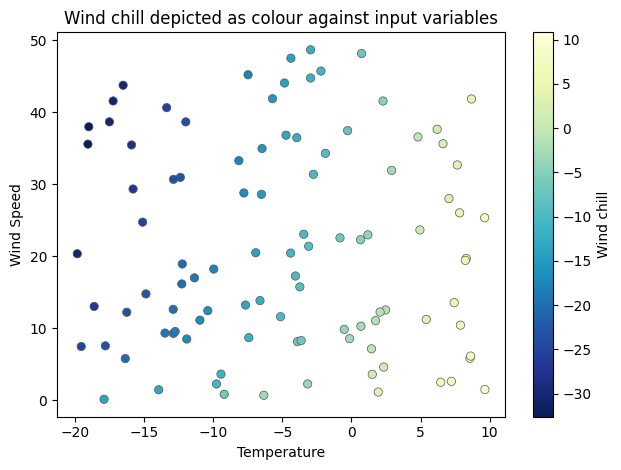

In [53]:
# Create a scatter plot for the wind chill estimates
data = y_pred.detach().numpy()
plt.scatter(temp_validation, wspd_validation, c=data, cmap="YlGnBu_r", edgecolor="#555555", linewidth=0.5)
plt.xlabel("Temperature")
plt.ylabel("Wind Speed")

plt.title("Wind chill depicted as colour against input variables")
plt.colorbar(label="Wind chill")
plt.tight_layout()

Now, we plot the same data points, but show the degree of error using the depth of colour (red is positive, blue is negative).

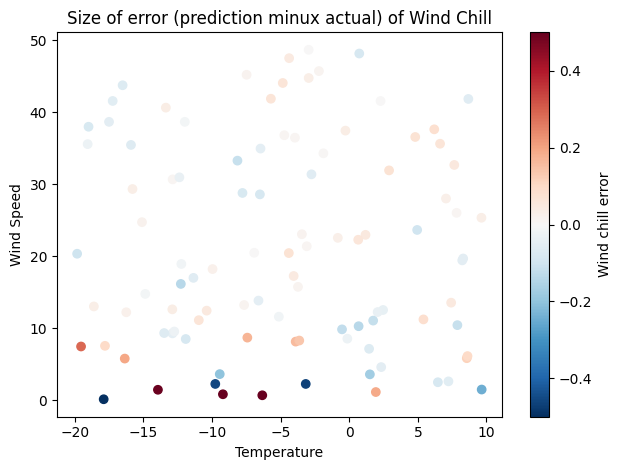

In [54]:
data = (y_pred - y_val).detach().numpy()
plt.scatter(temp_validation, wspd_validation, c=data, vmin=-0.5, vmax=0.5, cmap="RdBu_r")
plt.xlabel("Temperature")
plt.ylabel("Wind Speed")
plt.title("Size of error (prediction minux actual) of Wind Chill")
plt.colorbar(label="Wind chill error")
plt.tight_layout()

## Improving the Neural Network model

We can start to play with some parameters to improve the model.

Here we will change the number of nodes in the hidden layers to 50 instead of 20.

Additionally, we'll adjust the learning rate, to `lr=0.00025` and run for 20,000 intead of 10,000 epochs.

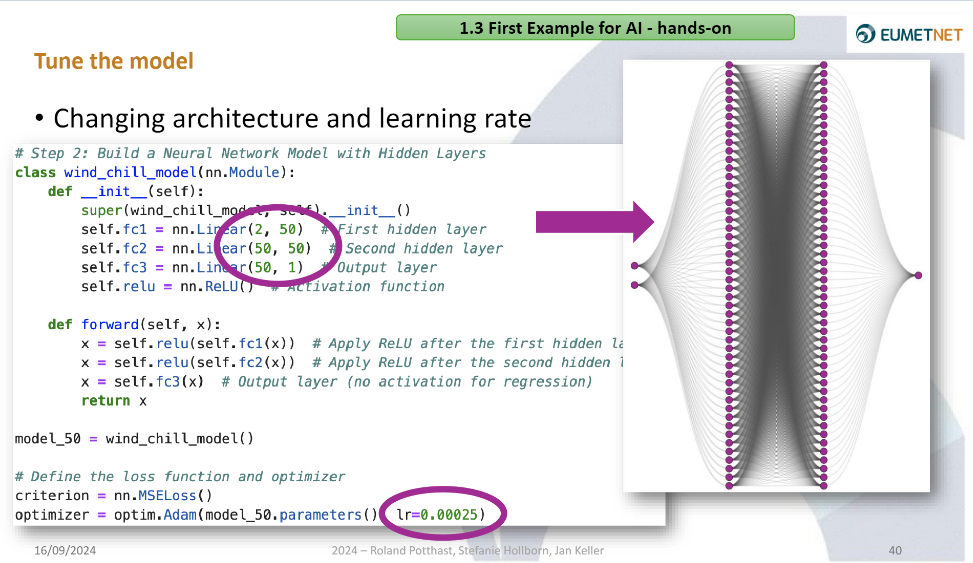

In [55]:
# Step 2: Build a Neural Network Model with Hidden Layers
class WindChillModel2(nn.Module):
    def __init__(self):
        super(WindChillModel2, self).__init__()
        self.fc1 = nn.Linear(2, 50)  # First hidden layer - now upped to 50 nodes
        self.fc2 = nn.Linear(50, 50)  # Second hidden layer
        self.fc3 = nn.Linear(50, 1)  # Output layer
        self.relu = nn.ReLU()  # Activation function
    
    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply ReLU after the first hidden layer
        x = self.relu(self.fc2(x))  # Apply ReLU after the second hidden layer
        x = self.fc3(x)  # Output layer (no activation for regression)
        return x

model_50 = WindChillModel2()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_50.parameters(), lr=0.00025)

In [56]:
show_model_params(model_50)

The model weights and biases (parameters) are:
	Shape = torch.Size([50, 2]); First few: [0.59140545129776, 0.30176693201065063, 0.3544188141822815]
	Shape = torch.Size([50]); First few: [-0.18513059616088867, 0.20389002561569214, -0.6515409350395203]
	Shape = torch.Size([50, 50]); First few: [-0.05260258913040161, 0.03966546058654785, -0.1175631582736969]
	Shape = torch.Size([50]); First few: [-0.01840134710073471, -0.05137864500284195, 0.05552877485752106]
	Shape = torch.Size([1, 50]); First few: [0.13394077122211456]
	Shape = torch.Size([1]); First few: [-0.003001183271408081]


Let's train the new model and examine the loss

In [57]:
train_loss = []
validation_loss = []

# Training loop
n_epochs = 20_000

for epoch in range(n_epochs):
    model_50.train()
    optimizer.zero_grad()
    
    y_pred = model_50(x_train)
    loss = criterion(y_pred,y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1} / {n_epochs}], Loss: {loss.item():.4f}')

    train_loss.append(loss.item())
    y_pred = model_50(x_val)
    vloss = criterion(y_pred, y_val)
    validation_loss.append(vloss.item())

Epoch [1000 / 20000], Loss: 0.5070
Epoch [2000 / 20000], Loss: 0.1186
Epoch [3000 / 20000], Loss: 0.0244
Epoch [4000 / 20000], Loss: 0.0147
Epoch [5000 / 20000], Loss: 0.0103
Epoch [6000 / 20000], Loss: 0.0080
Epoch [7000 / 20000], Loss: 0.0064
Epoch [8000 / 20000], Loss: 0.0049
Epoch [9000 / 20000], Loss: 0.0039
Epoch [10000 / 20000], Loss: 0.0037
Epoch [11000 / 20000], Loss: 0.0027
Epoch [12000 / 20000], Loss: 0.0024
Epoch [13000 / 20000], Loss: 0.0020
Epoch [14000 / 20000], Loss: 0.0015
Epoch [15000 / 20000], Loss: 0.0013
Epoch [16000 / 20000], Loss: 0.0012
Epoch [17000 / 20000], Loss: 0.0011
Epoch [18000 / 20000], Loss: 0.0016
Epoch [19000 / 20000], Loss: 0.0011
Epoch [20000 / 20000], Loss: 0.0010


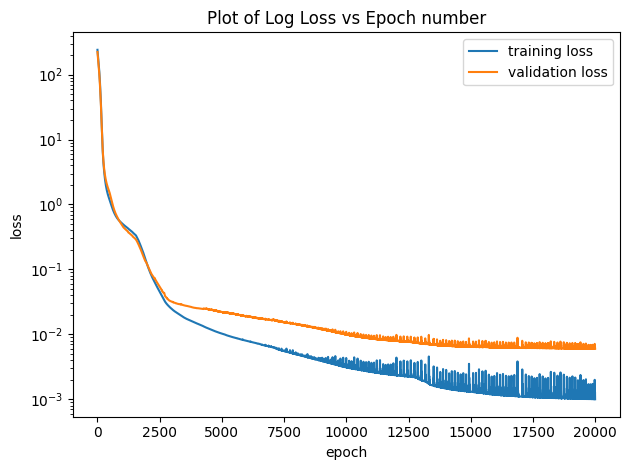

In [58]:
# Plot loss curves: training and validation
plot_loss_curves({"training loss": train_loss, "validation loss": validation_loss}, n_epochs)

### What do we learn by tracking the Validation Loss in the above example?

Here are some reasons why it is useful to look at the validation loss alongside the actual training loss (even though the validation loss does _not_ interfere with the training):
1. **Generalisation**: Assess the model's performance on unseen data - does it generalise well?
2. **Overfitting Detection**: Identify when the model is fitting the training data too closely.
3. **Early Stopping**: Stop training when further improvements on validation data cease.
4. **Hyperparameter Tuning**: Fine-tune model settings based on validation performance.
5. **Comparison**: Compare models for the best generalization performance.

By tracking validation loss during training, you ensure that the model isn't just memorizing the training data but learning patterns that will help it perform well on real-world data.

And let's create the same plots as last time, using the new model and data.

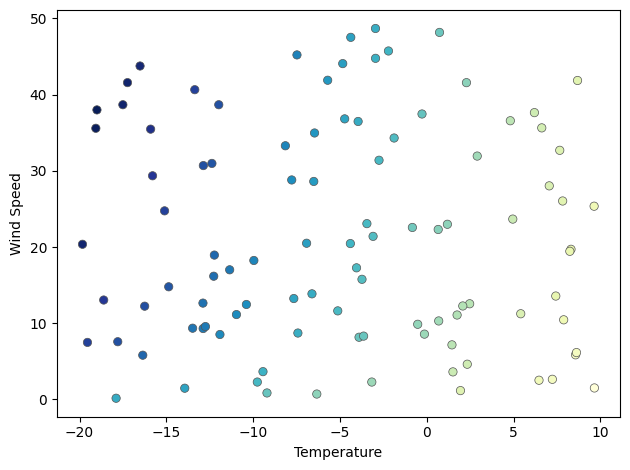

In [59]:
# Make the predictions with the model
y_pred = model_50(x_val)

# Create a scatter plot for the wind chill estimates
data = y_pred.detach().numpy()
plt.scatter(temp_validation, wspd_validation, c=data, cmap="YlGnBu_r", edgecolor="#555555", linewidth=0.5)

plt.xlabel("Temperature")
plt.ylabel("Wind Speed")
plt.tight_layout()

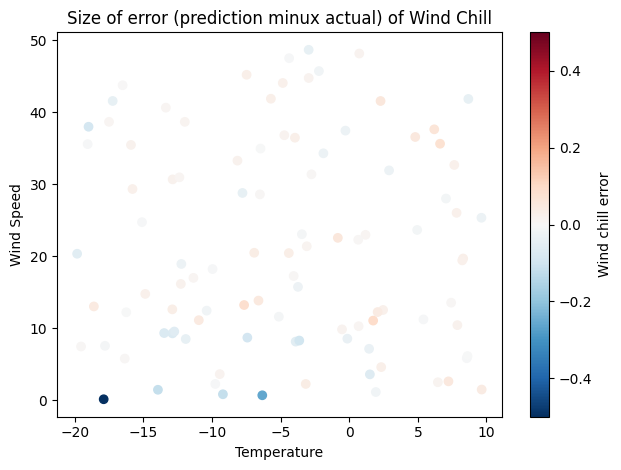

In [60]:
data = (y_pred - y_val).detach().numpy()
plt.scatter(temp_validation, wspd_validation, c=data, vmin=-0.5, vmax=0.5, cmap="RdBu_r")
plt.xlabel("Temperature")
plt.ylabel("Wind Speed")
plt.title("Size of error (prediction minux actual) of Wind Chill")
plt.colorbar(label="Wind chill error")
plt.tight_layout()

The size of the errors has been considerably reduced by:
1. Increasing the number of nodes in the hidden layers of the neural network.
2. Choosing a slower learning rate.
3. Doubling the number of training epochs.

NOTE: all of the above will use more energy and make the training process slower!